In [1]:
import numpy as np 

import tensorflow as tf
import tensorflow_probability as tfp
# -- plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [35]:
Mhalo = tf.convert_to_tensor(np.random.uniform(11.4, 15., 1000), dtype=tf.float32)
siglogm = tf.convert_to_tensor(0.2, dtype=tf.float32)
temperature = 0.2

def Ncen(Mmin): 
    # mean occupation of centrals
    return tf.clip_by_value(0.5 * (1+tf.math.erf((Mhalo - Mmin)/siglogm)), 1.e-4, 1 -1e-4)

def Nsat(Mmin, M0, M1, alpha):
    # mean occupation of satellites
    return tf.clip_by_value(0.5 * (1+tf.math.erf((Mhalo - Mmin)/siglogm))*( (10**Mhalo - 10**M0)/10**M1 )**alpha, 1.e-4, 1000)

def hod(Mmin, M0, M1, alpha): 
    central = tfp.distributions.RelaxedBernoulli(temperature, probs=Ncen(Mmin))
    sats = tfp.distributions.Poisson(rate=Nsat(Mmin, M0, M1, alpha))
    return central.sample(), tf.stop_gradient(sats.sample() - sats.rate) + sats.rate

def numden(Mmin, M0, M1, alpha): 
    cen, sat = hod(Mmin, M0, M1, alpha)
    return tf.reduce_sum(cen + sat)

(10.0, 15.0)

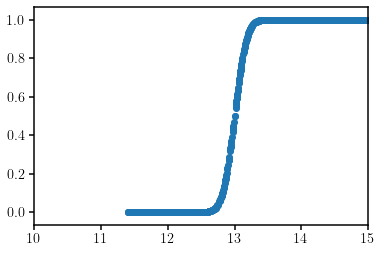

In [36]:
ncen = Ncen(13.0)
plt.scatter(Mhalo, ncen)
plt.xlim(10., 15.)

(10.0, 15.0)

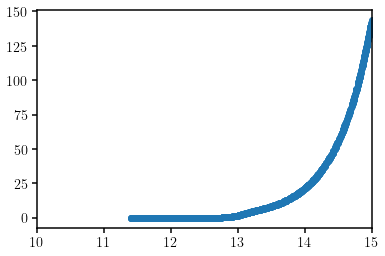

In [37]:
nsat = Nsat(13.0, 11.2, 12.4, 0.83)
plt.scatter(Mhalo, nsat)
plt.xlim(10., 15.)

(10.0, 15.0)

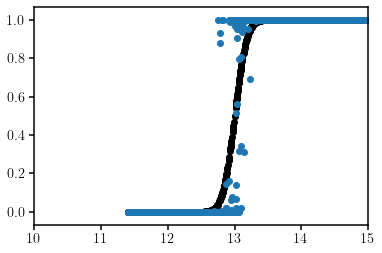

In [38]:
plt.scatter(Mhalo, ncen, c='k')
plt.scatter(Mhalo, hod(13., 11.2, 12.4, 0.83)[0])
plt.xlim(10., 15.)

(11.0, 15.0)

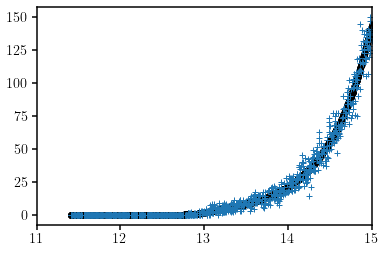

In [39]:
plt.scatter(Mhalo, nsat, c='k')
plt.plot(Mhalo, hod(13., 11.2, 12.4, 0.83)[1], '+')
plt.xlim(11., 15.)

In [114]:
Mmin_true = 13.
M0_true = 11.2
M1_true = 12.4
alpha_true = 0.83

numden_true = numden(Mmin_true, M0_true, M1_true, alpha_true).numpy()
print(numden_true)

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

_Mmin = tf.Variable(13.2, trainable=True, dtype=tf.float32)
_M1 = tf.Variable(12.4, trainable=True, dtype=tf.float32)
_alpha = tf.Variable(1., trainable=True, dtype=tf.float32)
trainable_variables = [_Mmin, _M1, _alpha]

22733.787


In [115]:
mass_hist = []
m1_hist = []
a_hist = []
for i in range(200):
    with tf.GradientTape() as tape:
        loss = (numden_true - numden(_Mmin, M0_true, _M1, _alpha))**2
    gradients = tape.gradient(loss, [_Mmin,  _alpha])
    opt.apply_gradients(zip(gradients, [_Mmin,  _alpha]))
    mass_hist.append(_Mmin.numpy())
    m1_hist.append(_M1.numpy())
    a_hist.append(_alpha.numpy())

In [116]:
_Mmin, _M1, _alpha

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=13.356468>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=12.4>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.83220726>)

In [117]:
numden(_Mmin, M0_true, _M1, _alpha)

<tf.Tensor: id=1775104, shape=(), dtype=float32, numpy=22728.54>

(0, 200)

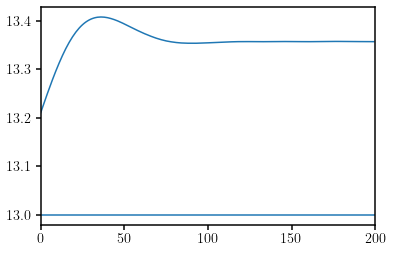

In [119]:
plt.plot(mass_hist)
plt.axhline(Mmin_true)
plt.xlim(0,200)

(0, 200)

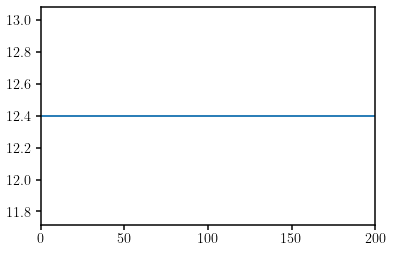

In [120]:
plt.plot(m1_hist)
plt.axhline(M1_true)
plt.xlim(0,200)

Text(0, 0.5, 'Alpha param')

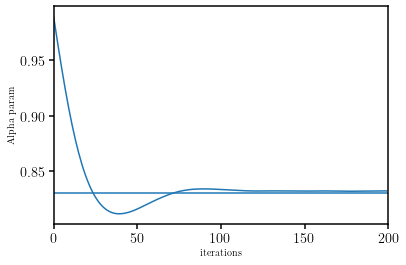

In [123]:
plt.plot(a_hist,'-')
plt.axhline(alpha_true)
plt.xlim(0,200)
xlabel('iterations')
ylabel('Alpha param')

Populating the interactive namespace from numpy and matplotlib


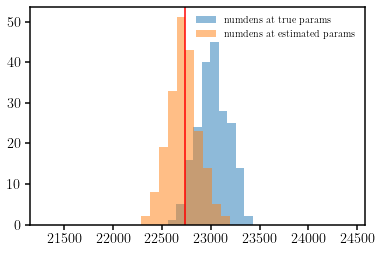

In [122]:
%pylab inline
hist([numden(13., 11.2, 12.4, 0.83) for i in range(200)],alpha=0.5, label='numdens at true params');
hist([numden(_Mmin, M0_true, _M1, _alpha) for i in range(200)],alpha=0.5, label='numdens at estimated params');
axvline(numden_true, color='red')
legend()